In [1]:
cd ..

/geode2/home/u020/deduggi/Carbonate/autonomous-robotics/bev-generation


In [2]:
import os
from pathlib import Path
import itertools
from io import BytesIO
import time
import json

import numpy as np
import scipy
import pandas as pd

import cv2

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

from sklearn.neighbors import KNeighborsClassifier

from nuscenes.nuscenes import NuScenes

import lmdb

from tqdm import tqdm

import utils
from utils import bytes_to_array
import nusc_utils

from bev_gt import generate_gt_bev_map
from bev2 import BEV, generate_bev_seg_map

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [83]:
import importlib
importlib.reload(utils)
importlib.reload(nusc_utils)
import bev2
importlib.reload(bev2)
from bev2 import BEV, generate_bev_seg_map

In [4]:
%%time
dataroot = Path('/N/slate/deduggi/nuScenes-trainval').resolve()
nuscenes = NuScenes(version='v1.0-trainval', dataroot=str(dataroot), verbose=False)
scene_idx = 0
sample_idx = 30

CPU times: user 39.7 s, sys: 5.34 s, total: 45 s
Wall time: 45.3 s


In [5]:
scene = nuscenes.scene[scene_idx]
sample = list(nusc_utils.sample_gen(nuscenes, scene))[sample_idx]

In [35]:
bev_gt_map = generate_gt_bev_map(nuscenes, scene, sample)

In [84]:
bev_seg_map, nusc_idx_to_color = generate_bev_seg_map(nuscenes, sample)

In [87]:
bev_gt_map_cmp = utils.make_composite(bev_gt_map)
bev_seg_map_cmp = utils.make_composite(bev_seg_map)

In [90]:
color_map = {i + 1: c for i, c in nusc_idx_to_color.items()}
color_map[0] = [255, 255, 255]
color_map[2] = [255, 255, 255]  # do not plot "other_flat"
color_map[4] = [255, 255, 255]  # do not plot "terrain"
color_map[15] = [255, 255, 255]  # do not plot "lidar mask"


In [91]:
bev_gt_map_cmp_color = utils.color_components(bev_gt_map_cmp, color_map=color_map)
bev_seg_map_cmp_color = utils.color_components(bev_seg_map_cmp, color_map=color_map)

(-0.5, 199.5, 199.5, -0.5)

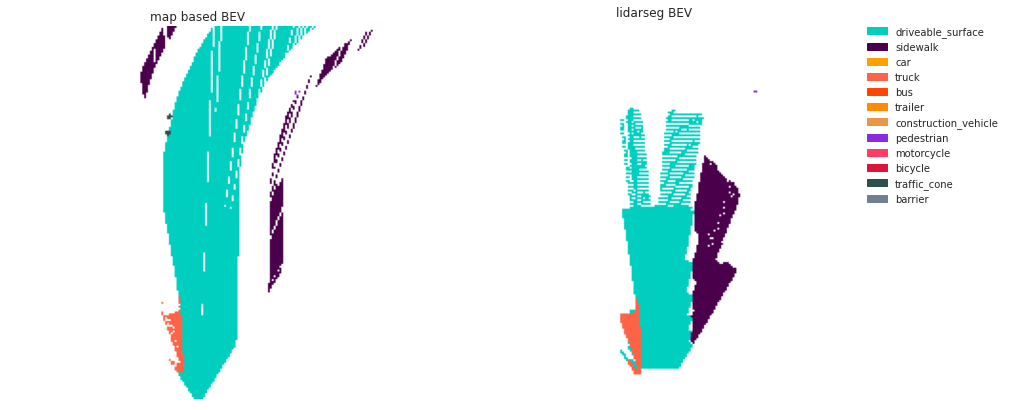

In [109]:
fig, axs = plt.subplots(ncols=2, figsize=(15, 7))
ax = axs[0]
ax.imshow(cv2.flip(bev_gt_map_cmp_color, 0))
ax.set_title('map based BEV')
ax.axis('off')

ax = axs[1]
ax.imshow(bev_seg_map_cmp_color)
ax.set_title('lidarseg BEV')

legend_colors = [np.append(np.array(nusc_idx_to_color[idx]) / 255, 1) for idx in range(len(nusc_idx_to_color))]
patches = [mpatches.Patch(color=legend_colors[i], label=label)
           for i, label in enumerate(nusc_utils.NUSC_LIDAR_CLASS_NAMES) if i not in [1, 3]]
ax.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
ax.axis('off')

In [22]:
gt_db_path = dataroot / Path('lmdb/samples/GT_BEV_CAM_FRONT')

In [31]:
db_map_size = int(15 * 1024 * 1024 * 1024)
with lmdb.open(path=str(gt_db_path), map_size=db_map_size, readonly=True) as lmdb_env:
    N = lmdb_env.stat()['entries']
    print(N)

34149


In [26]:
raw_db_path = dataroot / Path('lmdb/samples/RAW_BEV_CAM_FRONT')
db_map_size = int(15 * 1024 * 1024 * 1024)
with lmdb.open(path=str(raw_db_path), map_size=db_map_size, readonly=True) as lmdb_env:
    N = lmdb_env.stat()['entries']
    print(N)

34149


In [105]:
import zlib

In [106]:
key = str.encode(sample['data']['CAM_FRONT'], 'utf-8')
with lmdb.open(path=str(gt_db_path), map_size=db_map_size, readonly=True) as lmdb_env:
    with lmdb_env.begin() as txn:
        value = txn.get(key)
bev_gt = bytes_to_array(zlib.decompress(value))
bev_gt.shape

(15, 196, 200)

In [107]:
bev_gt_map_cmp = utils.make_composite(bev_gt)
bev_gt_map_cmp_color = utils.color_components(bev_gt_map_cmp, color_map=color_map)

In [12]:
tokens = {}
for scene in nuscenes.scene:
    scene_data = {}
    for sample in nusc_utils.sample_gen(nuscenes, scene):
        camera_data_token = sample['data']['CAM_FRONT']
        lidar_token = sample['data']['LIDAR_TOP']
        camera_data = nuscenes.get('sample_data', camera_data_token)
        scene_data[sample['token']] = {
            'CAM_FRONT': {
                'token': camera_data_token,
                'filename': camera_data['filename']
            },
            'LIDAR_TOP': lidar_token
        }
        
    tokens[scene['name']] = scene
    tokens[scene['name']]['scene_data'] = scene_data

In [16]:
import sys

In [17]:
sys.getsizeof(tokens)

36960

In [18]:
with open('v1.0-trainval-meta-custom.json', 'w') as f:
    json.dump(tokens, f)

In [19]:
cam_front_keys = [s2['CAM_FRONT']['token'] for s in tokens.values() for s2 in s['scene_data'].values()]

In [20]:
len(cam_front_keys)

34149

In [ ]:
raw_db_path = dataroot / Path('lmdb/samples/RAW_BEV_CAM_FRONT')
db_map_size = int(15 * 1024 * 1024 * 1024)
with lmdb.open(path=str(raw_db_path), map_size=db_map_size, readonly=True) as lmdb_env:
    N = lmdb_env.stat()['entries']
    print(N)